# Geodatenanalyse 1

## Übung 12: Kartendarstellungen in Python 

In [8]:
# [1]

import cartopy
import cartopy.crs as ccrs
import geopandas as geopd
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np
import shapely as shp

### Übung 1: Einfache Karten mit *Cartopy*

In dieser Übung geht es um die Erstellung von einfachen Karten:

#### Aufgabe 1

Bilde Deutschland auf einer Karte ab. Verwende dazu die UTM Projektion (Zone 32). Benutzt dazu die Funktion `cartopy.crs.UTM(zone=32)`. 

Zeichnet auch die Küstenlinien und die Landesgrenzen ein.

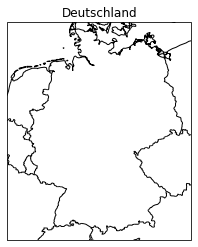

In [9]:
# [2] 
# eine Achse erstellen und die Projektion definieren
ax = plt.axes(projection=ccrs.UTM(zone=32))

# die features Küstenlinien und Landesgrenzen hinzufügen
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS)

# den Kartenausschnitt festlegen
ax.set_extent([5, 15, 47, 55])

# Kartentitel
ax.set_title('Deutschland')

plt.show()

#### Aufgabe 2

Zeichne mit Hilfe von Geolokation und *Geopy* deinen Geburtsort als roten Punkt auf diese Karte. Verändere dafür ggfs. den Kartenausschnitt. 

Achtung: Die Koordinaten aus *Geopy* müssen über das Argument `transform=ccrs.KBS` in das Koordinatensystem deiner Karte transformiert werden! KBS steht für Koordinatenbezugssystem, wobei bei `transform` das Ausgangs-KBS angegeben wird. Im Falle der Geolokation mit *Geopy* ist das `Geodetic()`. 

(51.3154546, 9.4924096)


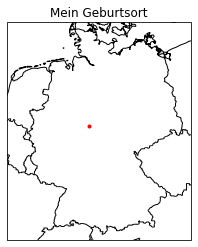

In [10]:
# [3]
# eine Achse erstellen und die Projektion definieren
ax = plt.axes(projection=ccrs.UTM(zone=32))

# die features Küstenlinien und Landesgrenzen hinzufügen
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS)

# Geolokation mit Geopy
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Example")
location = geolocator.geocode("Kassel, Germany")
print(location[1])

# Lokation auf der Achse darstellen, transform-Argument benutzen 
ax.plot(location[1][1], location[1][0], markersize=3, marker='o', color='red', transform=ccrs.Geodetic())

# den Kartenausschnitt festlegen
ax.set_extent([5, 15, 47, 55])

# Kartentitel
ax.set_title('Mein Geburtsort')

plt.show()


### Übung 2: Geopandas und Hintergrundkarten 

Die Datei *data/Messstellen_Karlsruhe.xlsx* enthält eine Liste von Grundwassermessstellen im Stadtgebiet von Karlsruhe. Die Koordinaten für diese Messstellen sind in DHDN (3-degree Gauss-Kruger Zone 3) angegeben.

#### Aufgabe 1

- Lese zunächst den Datensatz als Pandas DataFrame ein. Er enthält Spalten mit den Rechts- und Hochwerten, die jedoch erstmal bloße Zahlen darstellen. 

- Damit diese einen räumlichen Bezug bekommen, müssen diesen mit Hilfe von *Shapely* Geometrien zugewiesen werden. Im Falle von Messstellen also Punkte. Erstelle mit Hilfe eines for-loops einen neuen DataFrame, der zeilenweise für jede Messstelle die entsprechend Geometrie erzeugt. Benutze dafür den Befehl: `shapely.geometry.Point(Rechtswert, Hochwert)`. 

- Erzeuge dann einen GeoDataFrame, basierend auf dem DataFrame unter Angabe der Projektion `crs="EPSG:31467"`und der Geometrie `geometry=Geometrie` 

- Transformiere anschließend die Koordinaten der Messstellen in das WGS84 Koordinatensystem (`GeoDataFrame.to_crs('epsg:4326')`) und speichere die Ergebnisse als Shape-Datei.


In [11]:
# [4] 

# Daten einlesen als DataFrame
df = pd.read_excel('Messstellen_Karlsruhe.xlsx')
#df = pd.read_csv('Messstellen_Karlsruhe.csv', delimiter=";")

# Geometrien erzeugen, z.B. mit Hilfe eines for-loops über alle Zeilen in dem DataFrame
geometry = []
for index, row in df.iterrows():
    geometry.append(shp.geometry.Point(row.Rechtswert, row.Hochwert))

# GeoDataFrame erzeugen
gdf = geopd.GeoDataFrame(df, crs="EPSG:31467", geometry=geometry)

# Ändere die Projektion in WGS84 ('epsg:4326')
wgs = gdf.to_crs('epsg:4326')

# speichern als Shape-Datei
wgs.to_file('Messstellen_Karlsruhe.shp')

#### Aufgabe 2

Erstelle eine Karte dieser Messstellen, auf der im Hintergrund das Stadtgebiet darstellt ist, z. B. mit Contextily oder OpenStreetMap. 

Falls die Karte, bzw. die Namen auf der Karte "verzerrt" wirken, ändere die Projektion so dass es besser aussieht ;)

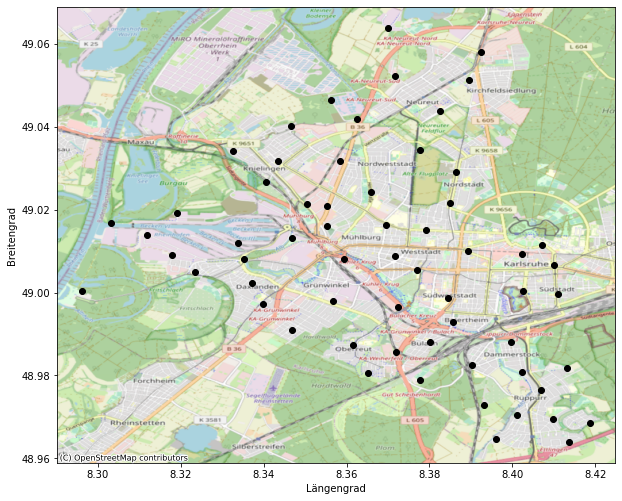

In [12]:
# [5] 

# Figure, bzw. Achsenobjekt erzeugen 
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# shapefile der Messstellen laden
monitoring = geopd.read_file("Messstellen_Karlsruhe.shp")

# ggfs. Projektion ändern
#monitoring=monitoring.to_crs("EPSG:31467") # Gauss-Krüger
#monitoring=monitoring.to_crs("EPSG:25832") # UTM Zone 32 N

# Messstellen darstellen
monitoring.plot(ax=ax, marker='o', c='k')

# Basemap hinzufügen 
ctx.add_basemap(ax, crs=monitoring.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik) # Straßenkarte
#ctx.add_basemap(ax, crs=monitoring.crs.to_string(), source=ctx.providers.OpenTopoMap) # Topografische Karte 

# Titel, Achsenbeschriftungen usw. hinzufügen
ax.set_xlabel('Längengrad')
ax.set_ylabel('Breitengrad')

plt.show()


## Ende